In [ ]:
"""
[TODO] Module docstring
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Point:
    """Two-dimensional point in Cartesian coordinate system

    Args:
        x_init (float): abscissa of the point
        y_init (float): ordinate of the point

    Attributes:
        x (float): abscissa of the point
        y (float): ordinate of the point

    """
    def __init__(self, x_init, y_init):
        self.x = x_init
        self.y = y_init

    def __repr__(self):
        return f"Point({self.x}, {self.y})"

    def __str__(self):
        return f"⟨{self.x}, {self.y}⟩"

    def __eq__(self, point):
        return abs(self.x - point.x) < 1e-6 and abs(self.y - point.y) < 1e-6

    def __add__(self, point):
        return Point(self.x + point.x, self.y + point.y)

    def __neg__(self):
        return Point(-self.x, -self.y)

    def __sub__(self, point):
        return self + (-point)

    def __mul__(self, coeff):
        return Point(self.x * coeff, self.y * coeff)

    def coordinates(self):
        """Returns the coordinates of the point into a list of two elements"""
        return [self.x, self.y]

    def distance(self, point):
        """Returns the Euclidian distance between the point and the Point point

        Examples:
        >>> np.round(Point(-8, 9 ).distance(Point( 0, 0)), 2)
        12.04
        >>> np.round(Point(10, 20).distance(Point(-4, 5)), 2)
        20.52
        >>> np.round(Point(-3, 5 ).distance(Point(-3, 5)), 2)
        0.0
        """
        return np.sqrt((self.x - point.x)**2 + (self.y - point.y)**2)

In [3]:
class Vector:
    """two-dimensional Euclidean vector
    Args:
        anchor (Point): initial point
        endpoint (Point): terminal point

    Attributes:
        x (float): scalar component along the x-axis of the vector
        y (float): scalar component along the y-axis of the vector
    """

    def __init__(self, anchor, endpoint):
        self.x = endpoint.x - anchor.x
        self.y = endpoint.y - anchor.y

    def __repr__(self):
        return f"Vector({self.x}, {self.y})"

    def __str__(self):
        return f"{{{self.x}, {self.y}}}"

    def dot(self, vector):
        """Dot product of the vector and another Vector vector"""
        return self.x * vector.x + self.y * vector.y

    def is_colinear(self, vector):
        """Check whether ot not the vector is colinear to the Vector vector"""
        return self.x * vector.y - vector.x * self.y == 0

#     def toArray(self):
#         return np.array([self.x, self.y])

In [9]:
class LineSegment:
    """real (directed) half-open line segment

    Args:
        anchor (Point): first end point of the line segment (exclude)
        endpoint (Point): second end point of the line segment (include)

    Attributes:
        anchor (Point): first end point of the line segment (exclude)
        endpoint (Point): second end point of the line segment (include)
    """
    def __init__(self, anchor, endpoint):
        self.anchor = anchor
        self.endpoint = endpoint

    def __repr__(self):
        return f"Ray({repr(self.anchor)}, {repr(self.endpoint)})"

    def __str__(self):
        return f"[{str(self.anchor)}⋯{str(self.endpoint)}]"

    @property
    def length(self):
        """Length of the line segment (i.e. distance between its endpoints)"""
        return self.anchor.distance(self.endpoint)

    def display(self, color='teal'):
        """Method used to plot the line segment"""
        x_values = [self.anchor.x, self.endpoint.x]
        y_values = [self.anchor.y, self.endpoint.y]
        plt.plot(x_values, y_values, 'o--', color=color)

    def contains(self, point):
        """Check whether or not the line segment contains the Point point

        Args:
            point (Point)

        Returns:
            bool: True if the point is contained in the line segment, False otherwise

        Examples:
        >>> LineSegment(Point(1, -2), Point(2, 0)).contains(Point(5, 6)) # working test
        False
        >>> LineSegment(Point(1, 0), Point(2, -1)).contains(Point(3, 1)) # working test
        False
        >>> LineSegment(Point(5, -1), Point(5, 4)).contains(Point(5, 0)) # vertical
        True
        """
        vec_a = Vector(self.anchor, self.endpoint)
        vec_b = Vector(self.anchor, point)
        return vec_a.is_colinear(vec_b) and 0 <= vec_a.dot(vec_b) <= vec_a.dot(vec_a)

    def line_equation_coeffs(self):
        """
        Returns:
            a, b, c (tuple of floats): Coefficients of the linear equation
                ax + by + c of the segment line
        N.B.:
            if (a, b, c) is a solution then λ(a, b, c) is also a solution

        Examples:
        >>> LineSegment(Point(3, 3),\
Point(2, 0)).line_equation_coeffs() # working test
        (-3, 1, -6)
        >>> LineSegment(Point(1, 2),\
Point(3, 2)).line_equation_coeffs() # a = 0
        (0, -2, -4)
        >>> LineSegment(Point(0, 0),\
Point(1, 3)).line_equation_coeffs() # c = 0
        (3, -1, 0)
        >>> LineSegment(Point(2, 2),\
Point(2, -1)).line_equation_coeffs()# b = 0
        (-3, 0, -6)
        """
        a = self.endpoint.y - self.anchor.y
        b = self.anchor.x - self.endpoint.x
        c = b * self.anchor.y + a * self.anchor.x
        return a, b, c

    def distance(self, point):
        """
        Returns:
            (float): Distance from a Point point to the line segment
                (considered here as a line)

        Examples:
        >>> np.round(LineSegment(Point(-1, 2), Point(2, 3)).distance(Point(1, 1)), 2)
        1.58
        >>> np.round(LineSegment(Point(0, 1), Point(0, 3)).distance(Point(-1, 0)), 2)
        1.0
        """
        a, b, c = self.line_equation_coeffs()
        return abs(b * point.y + a * point.x - c) / np.hypot(a, b)

    def intersects(self, seg):
        """Find intersection point between two oriented half-open line segments

        Since the two line segments are half-open at their endpoints:
            - If the (include) endpoints of the two line segments coincide, then
            the two line segments intersect at their endpoints
            - If the (exclude) anchors of the tow line segments coincide, then
            the two line segments DO NOT intersect at their anchors

        Args:
            seg (LineSegment): The line segment which may intersect

        Returns:
            (Point): The intersection point if the line segments intersect,
            None: otherwise

        Examples:
        >>> LineSegment(Point(-2, 2), Point(3, 4))\
.intersects(LineSegment(Point(1, 5), Point(1, 2))) # [p1, p2] and ]q1, q2[ intersect
        Point(1.0, 3.2)
        >>> LineSegment(Point(1, 2), Point(4, 2))\
.intersects(LineSegment(Point(-2,3), Point(-2,1)))
        >>> LineSegment(Point(2, 3), Point(2, 0))\
.intersects(LineSegment(Point(2, 2), Point(2, 1))) # colinear
        >>> LineSegment(Point(2, 3), Point(2, 0))\
.intersects(LineSegment(Point(1, 2), Point(1, -1))) # parallel
        """
        p1x, p1y = self.anchor.x, self.anchor.y
        p2x, p2y = self.endpoint.x, self.endpoint.y
        q1x, q1y = seg.anchor.x, seg.anchor.y
        q2x, q2y = seg.endpoint.x, seg.endpoint.y
        a = np.array([[q2x - q1x, p1x - p2x],
                      [q2y - q1y, p1y - p2y]])
        if np.linalg.det(a):  # if a is invertible (if lines intersect)
            b = np.array([p1x - q1x, p1y - q1y])
            t = np.linalg.solve(a, b)
            if np.all(t > 0) and np.all(t <= 1):  # segments intersect
                intersection = Point(
                    p1x + t[1] * (p2x - p1x), p1y + t[1] * (p2y - p1y))
                return intersection
        return None

In [10]:
class Polygon():
    """Simple polygon (the boundary of the polygon does not cross itself

    Args:
        *points (Points): ordered vertices of the polygon
            (The first point can ben repeated at the end or not)

    Attributes:
        points (list of Points): The vertices of the polygon
            The first vertice is repeated at the end (self.points[0] == self.points[-1])
    """
    def __init__(self, *points):
        self.points = list(points)
        if points[-1] != points[0]:
            self.points.append(points[0])

    def __len__(self):
        return max(len(self.points) - 1, 0)

    def get_edge(self, i):
        """Returns the i-th edge of the polygon

        Args:
            i (int): the index of the edge to be returned
        Returns:
            (LineSegment): the i-th edge of the poygon
        """
        return LineSegment(self.points[i], self.points[i+1])

    def get_all_edges(self):
        """Returns all the edges of the polygon

        Returns:
            (list of LineSegments): the edges of the polygon
        """
        return [self.get_edge(i) for i in range(len(self))]

    def display(self, color='C0'):
        """Method used to plot the polygon"""
        x_values = [p.x for p in self.points]
        y_values = [p.y for p in self.points]
        plt.fill(x_values, y_values, facecolor=color, alpha=0.3)
        plt.plot(x_values, y_values, '-o', color=color)

    @property
    def area(self):
        """Compute the area of the simple polygon"""
        area = 0
        for segment in self.get_all_edges():
            basis = (segment.endpoint.x - segment.anchor.x)
            heigth = 0.5 * (segment.endpoint.y + segment.anchor.y)
            area += basis * heigth
        return abs(area)

In [22]:
class Trajectory():
    """Trajectory

    Args:
        points (list of Points): ordered Points that define the trajectory
    
    Attributes:
        points (lisst of Points): ordered Points that define the trajectory
    """
    def __init__(self, points):
        self.points = points

    def get_line_segment(self, i):
        """Returns the i-th line segment of the trajectory""" 
        return LineSegment(self.points[i], self.points[i+1])

    def get_line_segments(self):
        """Returns all line segments that define the trajectory"""
        return [self.get_line_segment(i) for i in range(len(self.points) - 1)]

    def __repr__(self):
        return f"Trajectory({self.points})"

    def __str__(self):
        return "Ŧ[" + ", ".join([str(point) for point in self.points]) + "]"

    def __len__(self):
        """Number of points that constitute the trajectory"""
        return len(self.points)

    @property
    def length(self):
        """Total length of all line segments of the trajectory"""
        return sum([segment.length for segment in self.get_line_segments()])

    def display(self, color='C0'):
        """Method to plot the trajectory"""
        for segment in self.get_line_segments():
            segment.display(color)
    

    def find_intersecting_segments(self, traj):
        coord = []
        for i, segment in enumerate(self.get_line_segments()):
            intersection_points = []
            coord_inter = []
            for j, traj_segment in enumerate(traj.get_line_segments()):
                intersection = segment.intersects(traj_segment)
                if intersection:
                    intersection_points.append(intersection)
                    coord_inter.append((i, j))
            for j, traj_segment in enumerate(self.get_line_segments()):
                intersection = segment.intersects(traj_segment)
                if intersection:
                    intersection_points.append(intersection)
                    coord_inter.append((-i, -j))
            if len(coord_inter) > 0:
                d = dict(zip(coord_inter, intersection_points))
                sorted_x = np.array(
                    sorted(d.items(), key=lambda kv: kv[1].distance(segment.anchor)))
                coord.extend(sorted_x[:, 0])
        return coord

    def error_with(self, acquired, display=False):
        assert len(self) >= 2 and len(
            acquired) >= 1, "IncorrectInputTrajectories"
        error = 0
        Is = self.find_intersecting_segments(acquired)
        It = acquired.find_intersecting_segments(self)

        # Initializing the list of intersection points
        I = [(self.points[0] + acquired.points[0])*0.5]

        # Selectioning 'real' intersection points
        si, ti = [0], [0]  # breakpoints
        for i, (s, t) in enumerate(zip(Is, It)):
            # print(Js[i], Jt[i], Js[i] == Jt[i])
            if s[0] == t[1] and s[1] == t[0]:
                # print(s, t, Js[i], Jt[i])
                si.append(s[0]+1)
                ti.append(s[1]+1)
                I.append(self.get_line_segment(s[0]).intersects(
                    acquired.get_line_segment(s[1])))
        si.append(len(self))
        ti.append(len(acquired))
        I.append((self.points[-1] + acquired.points[-1])*0.5)

        # Split the two trajectories in multiple polygons
        for i in range(len(I) - 1):
            s_path = self.points[si[i]: si[i+1]]
            t_path = acquired.points[ti[i]: ti[i+1]][::-1]
            polygon = Polygon(I[i], *s_path, I[i+1], *t_path)
            if display:
                polygon.display(f"C{i}")
            error += polygon.area
        return error / self.length


In [23]:
def fetch_data(filename, contains_solution=True, sep=','):
    """
    >>> fetch_data("tests/shared-oracles/Oracles/CorrectInputTrajectories/\
10_parallelTrajectories.txt")[1:]
    [Trajectory([Point(1.0, 1.0), Point(3.0, 1.0)]),\
Trajectory([Point(1.0, 2.0), Point(3.0, 2.0)]), 1.0, 0.001]
    >>> fetch_data("tests/shared-oracles/Oracles/IncorrectInputTrajectories/\
3_EmptyAcquiredTrajectory.txt", False)[1:]
    [Trajectory([Point(0.0, 0.0), Point(1.0, 0.0)]),\
Trajectory([])]
    >>> fetch_data("tests/shared-oracles/Oracles/IncorrectInputTrajectories/\
2_EmptyAcquiredTrajectory.txt", False)[1:]
    [Trajectory([Point(0.0, 1.0)]), Trajectory([])]
    """
    with open(filename, "r") as file:
        lines = file.read().splitlines()  # getting rid of \n
        data = [[float(n) for n in line.split(sep) if n]
                for line in lines]  # parse data

    # line 0 : x-axis of the reference trajectory, line 1 : y-axis
    reference_coord = list(zip(data[0], data[1]))
    # line 2 : x-axis of the acquired trajectory, line 3 : y-axis
    acquired_coord = list(zip(data[2], data[3]))
    reference = Trajectory([Point(x, y) for x, y in reference_coord])
    acquired = Trajectory([Point(x, y) for x, y in acquired_coord])

    if contains_solution:
        expected_output, = data[4] or [-1]
        epsilon, = data[5] or [-1]
        return [filename, reference, acquired, expected_output, epsilon]
    return [filename, reference, acquired]

0.5496327358176604


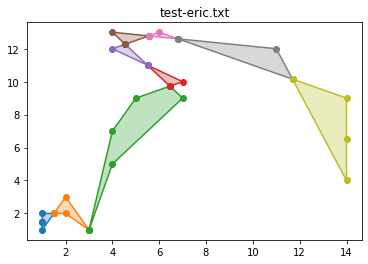

In [28]:
if __name__ == "__main__":
    # DIRNAME = "tests/shared-oracles/Oracles/EvaluationTrajectories"
    # FILENAME = "/oracle_etienne.txt"
    DIRNAME = "tests/perso-tests/"
    FILENAME = "test-eric.txt"
    NAME, A, B = fetch_data(DIRNAME + FILENAME, False)
    # inside notebook: to use the Trajectory class defined in notebook,
    # instead of using the one given by the estimator.py
    A, B = Trajectory(A.points), Trajectory(B.points)
    print(A.error_with(B, display=True))
    plt.title(NAME.split("/")[-1])